In [24]:
import numpy as np
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)

# Qiskit (Chemistry) tutorial

## Obtaining the Qubit Hamiltonian

### Define the molecule

Here we're looking at $H_2$ at a bond distance of $0.735$ Angstrom.

In [2]:
from qiskit_nature.drivers import Molecule
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)

### Selection of the orbital basis and Chemistry driver

Then, we define the basis and the driver we want to use to calculate the one- and two-body integrals. Here we use the STO-3G basis and the PySCF driver.

In [3]:
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver

driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

### Construction of the _Fermionic_ Hamiltonian

Qiskit Nature uses a special class to describe electronic structure problems, the `ElectronicStructureProblem`, which calls the driver and constructs the fermionic Hamiltonian. This class can also be passed into Qiskit Nature's algorithms for ground state search, as we'll see later.

In [4]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=4, number terms=14
  (0.18093119978423147+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423144+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423144+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.1809311997842317+0j) * ( -_0 +_1 -_2 +_3 ) ...


### Conversion to a _Qubit_ Hamiltonian

Now, we'll first find the ground state "manually" by doing the fermionic-to-qubit conversion ourselves and calling a algorithm to find the minimal eigenvalue, such as the VQE.

In [5]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)


-0.8105479805373264 * IIII
- 0.22575349222402508 * ZIII
+ 0.17218393261915543 * IZII
+ 0.1209126326177664 * ZZII
- 0.22575349222402505 * IIZI
+ 0.17464343068300475 * ZIZI
+ 0.16614543256382425 * IZZI
+ 0.17218393261915552 * IIIZ
+ 0.16614543256382425 * ZIIZ
+ 0.16892753870087926 * IZIZ
+ 0.1209126326177664 * IIZZ
+ 0.045232799946057875 * XXXX
+ 0.045232799946057875 * YYXX
+ 0.045232799946057875 * XXYY
+ 0.045232799946057875 * YYYY


There are different ways to construct the qubit Hamiltonian, with different advantages. In the Jordan-Wigner mapping for instance, qubit excitations correspond to electron numbers which allows to construct ansatze that are particle preserving. 

Other mappings, however, can reduce the number of required qubits to represent the problem and reduce the required qubit connectivities.

In [6]:
from qiskit_nature.mappers.second_quantization import ParityMapper

qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
print(qubit_op)

-1.0523732457728587 * II
+ (-0.3979374248431804+1.3877787807814457e-17j) * ZI
+ 0.3979374248431804 * IZ
+ (-0.01128010425623549+1.3877787807814457e-17j) * ZZ
+ 0.1809311997842315 * XX


## Finding the ground state

Now that we have the qubit Hamiltonian, let's find its minimum eigenvalue. Qiskit has several algorithms to solve this problem, which all implement the `MinimumEigensolver` interface.

To begin, we solve this small problem with matrix diagonalization to have an exact reference solution.

In [7]:
from qiskit.algorithms import NumPyMinimumEigensolver

classical_solver = NumPyMinimumEigensolver()

In [8]:
result = classical_solver.compute_minimum_eigenvalue(qubit_op)
print(result)
print(type(result))

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([-5.55111512e-17-4.77048956e-17j,
              7.22856695e-01+6.81936898e-01j,
             -8.11307233e-02-7.65380388e-02j,
              0.00000000e+00+5.55111512e-17j],
            dims=(2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': (-1.857275030202381+2.2391759836979376e-17j)}
<class 'qiskit.algorithms.minimum_eigen_solvers.minimum_eigen_solver.MinimumEigensolverResult'>


In [9]:
reference = result.eigenvalue.real
print(reference)

-1.857275030202381


### Variational Quantum Eigensolver

Let's solve this problem with a quantum algorithm: the VQE. 

The VQE requires several inputs, firstly a quantum backend or simulator to execute the circuits and calculate expectation values:

In [10]:
from qiskit.providers.aer import AerSimulator

sim = AerSimulator()

then, a classical optimizer for the feedback loop (see `qiskit.algorithm.optimizers` for more options):

In [11]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=300)

and finally a parameterized circuit to serve as ansatz for the wave function:

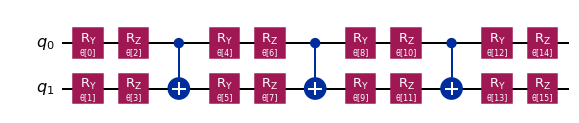

In [25]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(qubit_op.num_qubits)
ansatz.decompose().draw('mpl', style='iqx')

Note that there are many different ways to define the ansatz circuit, check out Qiskit's Circuit Library to see a set of examples!

With these ingredients we can define the VQE algorithm:

In [13]:
from qiskit.algorithms import VQE

vqe = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    quantum_instance=sim  # use qiskit.utils.QuantumInstance for error mitigation and other features
)

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


Since the `VQE` follows the same interface as the `NumPyEigensolver` they both have the `compute_minimum_eigenvalue` method:

In [14]:
vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)

In [15]:
print(vqe_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 600,
    'eigenstate': {   '00': 0.03125,
                      '01': 0.9926487608917869,
                      '10': 0.11692679333668567},
    'eigenvalue': (-1.856054923003748+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[15]): 2.9403050243413094,
                              ParameterVectorElement(θ[13]): -2.8438243548980044,
                              ParameterVectorElement(θ[12]): -1.8371360224319708,
                              ParameterVectorElement(θ[11]): 0.3212162266006088,
                              ParameterVectorElement(θ[10]): 3.8226363573732596,
                              ParameterVectorElement(θ[9]): 2.2015436215232405,
                              ParameterVectorElement(θ[8]): -0.5316146642309595,
                              ParameterVectorElement(θ[7]): 2.0830027513011715,
                              ParameterVectorElement(θ[6]): 2.074907088369654,
                         

In [16]:
print("Absolute error:", np.abs(vqe_result.eigenvalue - reference))

Absolute error: 0.0012201071986330803


With these result we can also reconstruct the optimal circuit:

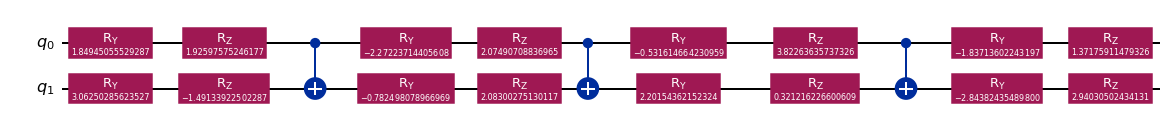

In [17]:
optimal_circuit = ansatz.bind_parameters(vqe_result.optimal_parameters)
optimal_circuit.decompose().draw(style='iqx')

Or get the statevector corresponding to the optimal circuit:

In [18]:
from qiskit.quantum_info import Statevector

optimal_sv = Statevector(optimal_circuit)
print(optimal_sv)

Statevector([-0.00709604+0.01975544j,  0.03543836-0.99391591j,
              0.00223912+0.10201644j, -0.00372928+0.00289436j],
            dims=(2, 2))


### Tracking the optimization

To get a feeling of whether our optimization is working we can also keep track of the function evaluations with a callback.

In [19]:
energies = []
nfevs = []
def callback(eval_count, params, energy, std):
    energies.append(energy)  # store the current energy
    nfevs.append(eval_count)  # store the current number of function evaluations
    
vqe = VQE(ansatz, optimizer, callback=callback, quantum_instance=sim)

In [20]:
vqe.compute_minimum_eigenvalue(qubit_op)

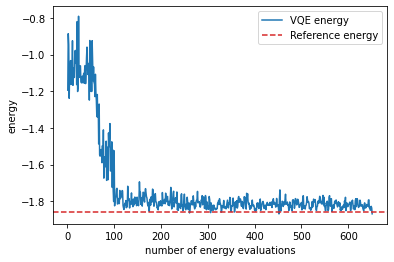

In [21]:
import matplotlib.pyplot as plt

plt.plot(nfevs, energies, label="VQE energy")
plt.axhline(y=reference, color="tab:red", ls="--", label="Reference energy")
plt.xlabel("number of energy evaluations")
plt.ylabel("energy")
plt.legend(loc="best");

## Exploiting Qiskit Nature's workflow

Since the above is a very common workflow, Qiskit Nature allows to simplify it a bit and takes care of the fermionic-to-qubit Hamiltonian conversion and calls the `MinimumEigensolver` for you.

graph!!!

In [22]:
from qiskit_nature.algorithms import GroundStateEigensolver

gss = GroundStateEigensolver(qubit_converter, classical_solver)  # also works with vqe
gss_result = gss.solve(es_problem)

print(gss_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [23]:
gss = GroundStateEigensolver(qubit_converter, vqe)  
gss_result = gss.solve(es_problem)

print(gss_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.86354747436
  - computed part:      -1.86354747436
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.143578479911
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: -0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
